<h2>CS 4780/5780 Final Project: </h2>
<h3>COVID-19 Hospitalizations Prediction for EU Countries</h3>

Names and NetIDs for your group members:

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is predicting hospitalizations due to COVID-19. Although hospitalizations are directly related to COVID-19 cases, the different populations, timelines and reactionary measures of different EU countries result in different trends in hospitalization numbers. In this project you will bring the power of machine learning to make predictions for the country-level hospitalizations using COVID-19 age group case data and also previous hospitalization data. There will be two tasks, one will be a basic problem that will require you to use methods learned in class. The second task will be more difficult and will require some additional intuition and insight. <b>Please read the project description PDF file carefully and follow the instructions there. Also make sure you write your code and answers to all the questions in this Jupyter Notebook </b> </p>
<p>


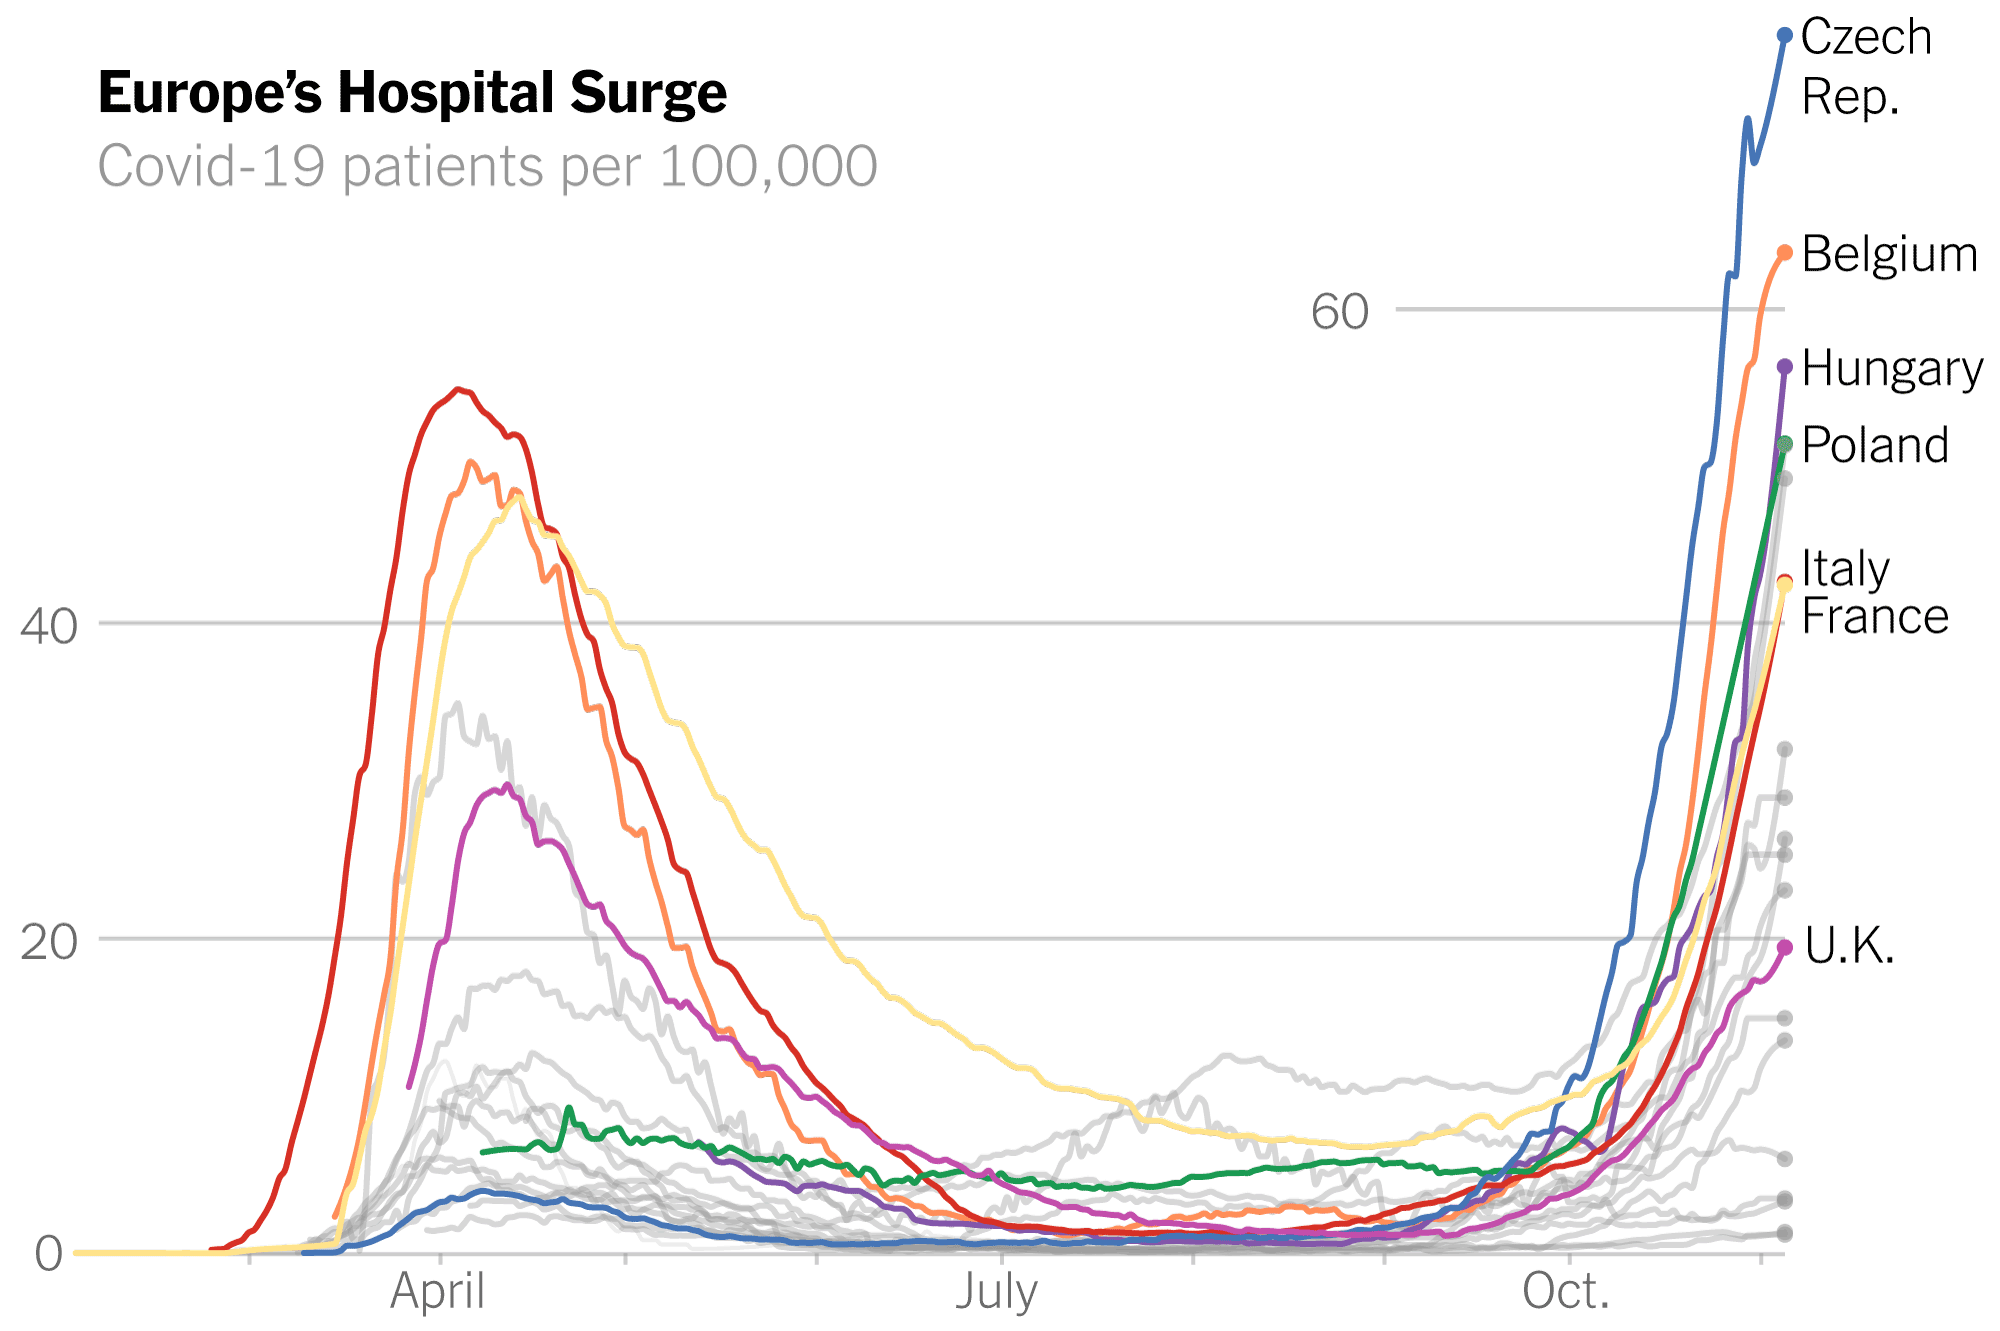

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, BayesianRidge, LogisticRegressionCV, Ridge, ElasticNetCV, LinearRegression
import sys
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import LinearSVC
from time import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
# from warnings import filterwarnings
# filterwarnings('ignore')
# TODO

<h3>1.2 Accuracy and Mean Squared Error:</h3><p>
To measure your performance in the Kaggle Competition, we are using accuracy and mean squared error (MSE). As a recap, accuracy is the percent of labels you predict correctly and MSE is the average squared difference between the estimated values and the actual value. To measure this, you can use library functions from sklearn. A simple example is shown below. 
<p>

In [2]:
from sklearn.metrics import accuracy_score
y_pred = [3, 2, 1, 0, 1, 2, 3]
y_true = [0, 1, 2, 3, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.42857142857142855

In [3]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_pred)

2.857142857142857

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). Think of what modifications can be done to the data to make it more easily interpretable.
<p>

In [4]:
# You may change this but we suggest loading data with the following code and you may need to change
# datatypes and do necessary data transformation after loading the raw data to the dataframe.
train = pd.read_csv('train_baseline.csv', sep=',', encoding='unicode_escape')
test = pd.read_csv('test_baseline_no_label.csv',  sep=',', encoding='unicode_escape')

# print(train['next_week_increase_decrease'].mean()) -> imbalanced data, more likely to 
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO

def onehot_general(df, attr, encodings, prefix = ""):
    df = df.copy()
    for thing in set(encodings):
        df[prefix + str(thing)] = (df[attr] == thing).astype(int)
    return df, list(set(df[attr]))

def onehot_general2(df, attr1, attr2, encodings1, encodings2):
    df = df.copy()
    for thing1 in set(encodings1):
        for thing2 in set(encodings2):
            df[str(thing1) + str(thing2)] = (df[attr1] == thing1).astype(int) & (df[attr2] == thing2).astype(int)
    return df

"""
Percentile binning df
"""
def percentile_binning_columns(df):
    per_25 = np.percentile(df['under_15_cases'],25)
    per_50 = np.percentile(df['under_15_cases'],50)
    per_75 = np.percentile(df['under_15_cases'],75)
    df['binned_15_25'] = np.where(df['under_15_cases']<per_25, 1,0)
    df['binned_15_50'] = np.where(df['under_15_cases']<per_50, 1,0)
    df['binned_15_75'] = np.where(df['under_15_cases']<per_75, 1,0)
    df['binned_15_100'] = np.where(df['under_15_cases']>per_75, 1,0)

    per_25 = np.percentile(df['15-24_cases'],25)
    per_50 = np.percentile(df['15-24_cases'],50)
    per_75 = np.percentile(df['15-24_cases'],75)
    df['binned_25_25'] = np.where(df['15-24_cases']<per_25, 1,0)
    df['binned_25_50'] = np.where(df['15-24_cases']<per_50, 1,0)
    df['binned_25_75'] = np.where(df['15-24_cases']<per_75, 1,0)
    df['binned_25_100'] = np.where(df['15-24_cases']>per_75, 1,0)

    per_25 = np.percentile(df['25-49_cases'],25)
    per_50 = np.percentile(df['25-49_cases'],50)
    per_75 = np.percentile(df['25-49_cases'],75)
    df['binned_50_25'] = np.where(df['25-49_cases']<per_25, 1,0)
    df['binned_50_50'] = np.where(df['25-49_cases']<per_50, 1,0)
    df['binned_50_75'] = np.where(df['25-49_cases']<per_75, 1,0)
    df['binned_50_100'] = np.where(df['25-49_cases']>per_75, 1,0)

    per_25 = np.percentile(df['50-64_cases'],25)
    per_50 = np.percentile(df['50-64_cases'],50)
    per_75 = np.percentile(df['50-64_cases'],75)
    df['binned_65_25'] = np.where(df['50-64_cases']<per_25, 1,0)
    df['binned_65_50'] = np.where(df['50-64_cases']<per_50, 1,0)
    df['binned_65_75'] = np.where(df['50-64_cases']<per_75, 1,0)
    df['binned_65_100'] = np.where(df['50-64_cases']>per_75, 1,0)

    per_25 = np.percentile(df['65-79_cases'],25)
    per_50 = np.percentile(df['65-79_cases'],50)
    per_75 = np.percentile(df['65-79_cases'],75)
    df['binned_80_25'] = np.where(df['65-79_cases']<per_25, 1,0)
    df['binned_80_50'] = np.where(df['65-79_cases']<per_50, 1,0)
    df['binned_80_75'] = np.where(df['65-79_cases']<per_75, 1,0)
    df['binned_80_100'] = np.where(df['65-79_cases']>per_75, 1,0)

    per_25 = np.percentile(df['over_80_cases'],25)
    per_50 = np.percentile(df['over_80_cases'],50)
    per_75 = np.percentile(df['over_80_cases'],75)
    df['binned_100_25'] = np.where(df['over_80_cases']<per_25, 1,0)
    df['binned_100_50'] = np.where(df['over_80_cases']<per_50, 1,0)
    df['binned_100_75'] = np.where(df['over_80_cases']<per_75, 1,0)
    df['binned_100_100'] = np.where(df['over_80_cases']>per_75, 1,0)

    return df

"""
Decision tree preprocessing
"""
def preprocessing_dt(df):
    df = percentile_binning_columns(df)
    df = onehot(df)
    df['date'] = pd.to_datetime(df['date'])
    smallest_date = min(df['date'])
    df['days'] = (df['date'] - smallest_date).apply(lambda x: x.days)
    mean = np.mean(df['Daily hospital occupancy'])
    stdev = np.std(df['Daily hospital occupancy'])
    df['Daily hospital occupancy'] = (df['Daily hospital occupancy']-mean)/stdev
    df = df.drop(['country','date','year_week','under_15_cases', '15-24_cases',
       '25-49_cases', '50-64_cases', '65-79_cases', 'over_80_cases'],axis=1)
    return df

"""
Forward feature selection, does selection if do_selection is true
"""
do_selection = False
def selection(x_train,y_train,feature_names):
    if do_selection:
        lsvc = LinearSVC(max_iter=100000, C = 0.1)
        tic_fwd = time()
        sfs_forward = SequentialFeatureSelector(lsvc,direction='forward').fit(x_train, y_train)
        sfs_forward.fit(x_train, y_train)
        return feature_names[sfs_forward.get_support()]
    else:
        return feature_names


"""
Processing countries
"""
def onehot(df):
    df = df.copy()
    for ctry in set(df['country']):
        df[ctry] = (df['country'] == ctry).astype(int)
    return df

    
"""
Processes test data and train data at the same time

country : onehot encoding
date : min-max scaling 
"""
def process_scale(test, train):
    test = test.copy()
    train = train.copy()

    """
    (1) One hot encoding of each country
    """
    train = onehot(train)
    test = onehot(test)

    """
    (2) Processing dates 
    """
    train['date'] = pd.to_datetime(train['date'])
    test['date'] = pd.to_datetime(test['date'])

    # earliest date in train dataset
    smallest_date = min(train['date'])

    # convert scales to an integer representing instead of a datae
    train['days'] = (train['date'] - smallest_date).apply(lambda x: x.days)
    test['days'] = (test['date'] - smallest_date).apply(lambda x: x.days)

    def train_minmax(df, feature):
        df1 = df.copy()
        mn = df[feature].min()
        mx = df[feature].max()
        df1[feature] = (df[feature] - mn) / (mx - mn)
        return df1, mn, mx
    
    def train_days_normalize(df, feature):
        df1 = df.copy()
        mean = df[feature].mean()
        std = df[feature].std()
        df1[feature] = (df[feature] - mean) / std
        return df1, mean, std

    train, mean, std = train_days_normalize(train, 'days')
    test['days'] = ((test['days'] - mean) / std)

    """
    (3) Standardizing other variables
    """
    to_normalize = ['Daily hospital occupancy','under_15_cases', '15-24_cases', '25-49_cases','50-64_cases', '65-79_cases', 'over_80_cases']
    to_normalize_w_country = to_normalize + ['country']


    scaler = preprocessing.StandardScaler().fit(train[to_normalize])
    train[to_normalize] = scaler.transform(train[to_normalize])
    test[to_normalize] = scaler.transform(test[to_normalize])


    cols_to_drop = ['country', 'date', 'year_week']
    train = train.drop(cols_to_drop, axis = 1)
    test = test.drop(cols_to_drop, axis = 1)
    
    # randomize train data
    df = train.sample(frac = 1, random_state = 0)

    trainX, trainy = df.loc[:,df.columns != 'next_week_increase_decrease'], df['next_week_increase_decrease']

    return test, trainX, trainy





<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [5]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4

# want to use multilevel perceptron neural networ


# TODO
"""
Neural network with one hidden layer
"""
mlp = MLPClassifier(max_iter = 300, solver = 'adam', learning_rate = 'constant', random_state= 0, activation = 'relu', early_stopping = True)
svm_classifier = svm.SVC()
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100)



<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [6]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO

"""
Processes data for neural network by using process_scale function from 2.1
"""
def decision_tree_calc (x_train,y_train, opt_alpha):
    decision_tree_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100, ccp_alpha = opt_alpha)
    decision_tree = decision_tree_model.fit(x_train,y_train)
    return decision_tree

def decision_tree_pruned (x_train, x_test, y_train, y_test):
    decision_tree_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100)
    path = decision_tree_model.cost_complexity_pruning_path(x_train, y_train)
    alphas, impurities = path.ccp_alphas, path.impurities
    tree = []
    for alpha in alphas:
        model = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
        model.fit(x_train, y_train)
        tree.append(model)
    #train_scores = [clf.score(x_train, y_train) for clf in clfs]
    test_scores = [model.score(x_test, y_test) for model in tree]
    pos = np.argmax(test_scores)
    opt_alpha = alphas[pos]
    return opt_alpha

def decision_tree_final_calculation(x_train, x_test, y_train, y_test):
    opt_alpha = decision_tree_pruned (x_train, x_test, y_train, y_test)
    decision_tree = decision_tree_calc(x_train, y_train, opt_alpha)
    y_pred = decision_tree.predict(x_test)
    y_pred = y_pred.tolist()
    y_test = y_test.tolist()
    accuracy = accuracy_score(y_test,y_pred)*100
    print("Accuracy is "+str(accuracy))
    return decision_tree, opt_alpha

def decision_tree_train(test, train):
    df = train
    df = preprocessing_dt(df)
    test = preprocessing_dt(test)
    x = df.values[:, ~df.columns.isin(['next_week_increase_decrease'])]
    y = df['next_week_increase_decrease'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)
    df_copy = df.copy()
    df = df.drop('next_week_increase_decrease',axis=1)
    x = df.values[:, ~df.columns.isin(['next_week_increase_decrease'])]
    y = df_copy['next_week_increase_decrease'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)

    decision_tree, opt_alpha = decision_tree_final_calculation(x_train, x_test, y_train, y_test)

    # train on whole data set and predict training data
    decision_tree = decision_tree_calc(x, y, opt_alpha)

    return test, decision_tree

def train_nn_grid_search(test, train):
    test_nn, train_X, train_y = process_scale(test, train)

    """
    (1) Split into train, val, test
    """
    trainval_percent = 0.8
    test_percent = 0.2

    Xtrval, Xtest, ytrval, ytest = train_test_split(train_X, train_y, test_size = test_percent)
    assert Xtrval.shape[1] == Xtest.shape[1]

    hidden_sizes = [80.0, 100.0, 120.0, 140.0, 180.0]
    hidden_layer_sizes = list(map(lambda x:(int(x),), hidden_sizes))
    alphas = 10.0 ** -np.arange(2,4)
    parameters = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': alphas}


    clf = GridSearchCV(mlp, parameters, n_jobs = -1, cv = 5).fit(Xtrval, ytrval)

    preds = clf.predict(Xtest)
    accuracy_estimate = accuracy_score(ytest, preds)
    
    clf_nn_best = clf.best_estimator_.fit(train_X, train_y)

    return test_nn, clf, clf_nn_best, accuracy_estimate


def train_svm_grid_search(test, train):
    test_svm, train_X, train_y = process_scale(test, train)
    
    """
    (1) Split into train, val, test
    """
    trainval_percent = 0.8
    test_percent = 0.2

    Xtrval, Xtest, ytrval, ytest = train_test_split(train_X, train_y, test_size = test_percent)
    assert Xtrval.shape[1] == Xtest.shape[1]

    c_ranges = [0.1, 1, 10, 70, 80, 100, 200, 300]
    kernels = ('linear', 'rbf', 'sigmoid', 'poly')
    # hidden_layer_sizes = list(map(lambda x:(int(x),), hidden_sizes))
    # alphas = 10.0 ** -np.arange(1,5)
    parameters = {'C': c_ranges, 'kernel': kernels}
    clf = GridSearchCV(svm_classifier, parameters, n_jobs = -1, cv = 5)
    clf.fit(Xtrval, ytrval)

    preds = clf.predict(Xtest)
    accuracy = accuracy_score(ytest, preds) 

    clf_svm_best = clf.best_estimator_.fit(train_X, train_y)

    return test_svm, clf, clf_svm_best, accuracy

test_svm, clf_svm, clf_svm_best, accuracy_svm = train_svm_grid_search(test, train)
test_nn, clf_nn, clf_nn_best, accuracy_nn = train_nn_grid_search(test, train)
test_dt, clf_dt = decision_tree_train(test, train)

Accuracy is 91.38795986622074


<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features, and how did you formulate the learning problem (or problems)?

Depending om

We proproccesed the data by using minimax scaling. We did this because we are using neural networks and SVM's which  

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

We decided we do not know much about the distribution of the data, so we focused on empircical risk minimization methods subjcet to certain constraints to minimize preiction error. 

One learning method we decided to use are support vector machines becuase of the theoretical garuntees on expected generalization error given by LOO error bounds. This bound is given by:

We didn't choose Naive Bayes because it assumes features are conditionally independent given the class label. This is not true at all for the one-hot encoded countries, and seems to be a strong assumption for COVID cases by age group.  

$$Es[err_P(SVM)] \le \frac{1}{m} * #SV's$$

This allows to have an useful upper bound on our prediction error. SVM's also allow us to use a kernel to allow for non-linear feature selection. In our model selection we do a cross-validation to determine the optimal hyperparamter values of C to determine how soft (low C) or hard-margin (high C) we want our classifer to be. It will also be interesting to see if our data is even linearly seperable.

Another learning method we decided to use are neural networks. Even though we don't know the distribution of our data, neural networks with non-linear activation functions and one large enough hidden layer can approximate any function on $\mathbb{R}^n$. Thus, I will use cross-validation to determine the hidden layer size.


2.4.3 How did you do the model selection?

We used k-fold cross-validaion with k = 5 to avoid overfititng. This is extremely easy with sklearn's GridSearchCV which looks at all combinations of parameters specified to do the cross-validation. With neural networks of one hidden layer we did cross-validation on values of alpha and hidden layer size


We assumed we didn't have balanced data overall. To test this we looked at the mean of the last column of the dataset, whether or not hospitalizations increased or decreased. The mean is ~0.43, which means we have more observations where hospitalizations decrease. Thus, 0-1 loss is not enough, and we took a look at some of the sklearn loss metrics that we could use here instea that don't asssume balance classes:

https://scikit-learn.org/stable/modules/model_evaluation.html

ROC as we learned in lecture seems very promosing, since it looks at both the true positive and false negative rate and works for imbalanced classes. ROC plots (TP / m+, FN / m-) over all examples ranked and checks to make sure we are doing better than random guessing based on the class labels. In this case, we don't use the sign activation function in the last layer of the neural network and instead output a real number between 0 and 1.

However, since 






2.4.4 Does the test performance reach a given baseline 70% performance? (Please include a screenshot of Kaggle Submission)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating/using new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 150k MSE creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [7]:
# Make sure you comment your code clearly and you may refer to these comments in the part 3.2
# TODO
train_creative = pd.read_csv('train_creative.csv', sep=',', encoding='unicode_escape')
train_creative_t_values = pd.read_csv('train_creative_t_values.csv', sep=',', encoding='unicode_escape')
test_creative = pd.read_csv('test_creative_no_label.csv',  sep=',', encoding='unicode_escape')
test_creative_original = test_creative.copy()
test_creative_t_values = pd.read_csv('test_creative_t_values.csv',  sep=',', encoding='unicode_escape')

test_creative_original = test_creative.copy()

# hypothesis: too many t-values creating overfitting
# last two weeks of t-values
t_cols_week_1 = list(train_creative_t_values.columns)[4:11]
t_cols_week_2 = list(train_creative_t_values.columns)[11:18]
t_cols_week_3 = list(train_creative_t_values.columns)[18:25]

"""
Add measure of if hospitalizations increased over the past week
"""
def add_deltas(df, df_t):
    df['delta past week'] = df_t[t_cols_week_1].mean(axis = 1) - df_t[t_cols_week_2].mean(axis = 1)
    df['delta past two weeks'] = df_t[t_cols_week_1].mean(axis = 1) - df_t[t_cols_week_3].mean(axis = 1)

add_deltas(train_creative, train_creative_t_values)
add_deltas(test_creative, test_creative_t_values)

"""
Adding population measure
"""
cases_cols = [col for col in train_creative.columns if 'cases' in col]
df_grouped = train_creative[cases_cols + ['country']].groupby('country')
country_sizes = {}
for k, v in list(df_grouped):
    country_sizes[k] = np.array(v[cases_cols]).sum()
country_sizes = pd.Series(country_sizes)
test_creative['population'] = [country_sizes[c] for c in test_creative['country']]
train_creative['population'] = [country_sizes[c] for c in train_creative['country']]


test_creative['old cases'] = test_creative['50-64_cases'] * 0.3 + test_creative['65-79_cases'] * 0.6 + test_creative['over_80_cases'] * 1.2
train_creative['old cases'] = train_creative['50-64_cases'] * 0.3 + train_creative['65-79_cases'] * 0.6 + train_creative['over_80_cases'] * 1.2

"""
One hot week of year encoding
"""
# train_creative, _ = onehot_general(train_creative, 'year_week', list(test_creative['year_week']) + list(train_creative['year_week']))
# test_creative, _ = onehot_general(test_creative, 'year_week', list(test_creative['year_week']) + list(train_creative['year_week']))

"""
One hot country encoding, add selected t_values
"""
t_cols = list(train_creative_t_values.columns)[4:10]
train_creative[t_cols] = train_creative_t_values[t_cols]
test_creative[t_cols] = test_creative_t_values[t_cols]
# add an idea of population
# use ordinary least squares 
train_creative = onehot(train_creative)
countries = list(set(train_creative['country']))
test_creative = onehot(test_creative)

"""
Date encoding
"""

train_creative['date'] = pd.to_datetime(train_creative['date'])
test_creative['date'] = pd.to_datetime(test_creative['date'])

# earliest date in train dataset
smallest_date = min(train_creative['date'])

# convert scales to an integer representing instead of a date
train_creative['days'] = (train_creative['date'] - smallest_date).apply(lambda x: x.days)
test_creative['days'] = (test_creative['date'] - smallest_date).apply(lambda x: x.days)

# add binary features for approx months
# train_creative['months'] = (train_creative['date'] - smallest_date).apply(lambda x: x.days // 30)
# test_creative['months'] = (test_creative['date'] - smallest_date).apply(lambda x: x.days // 30)

# train_creative, _ = onehot_general(train_creative, 'months', list(test_creative['months']) + list(train_creative['months']))
# test_creative, _ = onehot_general(test_creative, 'months', list(test_creative['months']) + list(train_creative['months']))

# one_hot for months and country
# train_creative = onehot_general2(train_creative, 'country', 'months', list(test_creative['country']) + list(train_creative['country']),list(test_creative['months']) + list(train_creative['months']))

# test_creative = onehot_general2(test_creative, 'country', 'months', list(test_creative['country']) + list(train_creative['country']), list(test_creative['months']) + list(train_creative['months']))

# make polynomail features more meaningful by 0-meaning
# mean = train_creative['days'].mean()
# std = train_creative['days'].std()

# train_creative['days'] = (train_creative['days'] - mean)
# test_creative['days'] = (test_creative['days'] - mean)

# poly = PolynomialFeatures(2)
# poly_train_days = poly.fit_transform(np.array(train_creative['days']).reshape(-1,1))
# poly_test_days = poly.fit_transform(np.array(test_creative['days']).reshape(-1,1))
# new_day_indices = ['days' + str(i) for i in range(poly_train_days.shape[1])]
# train_creative[new_day_indices] = poly_train_days
# test_creative[new_day_indices] = poly_test_days


del train_creative['country']
del test_creative['country']
del train_creative['date']
del test_creative['date']
del train_creative['year_week']
del test_creative['year_week']

"""
Feature normalization
"""

train_normalize_cols = train_creative.columns.difference(countries + ['next_week_hospitalizations'])
test_normalize_cols = test_creative.columns.difference(countries)

train_normalize = train_creative[train_normalize_cols]
test_normalize = test_creative[test_normalize_cols]

scaler = preprocessing.StandardScaler().fit(train_normalize)
train_creative[train_normalize_cols] = scaler.transform(train_normalize)
test_creative[test_normalize_cols] = scaler.transform(test_normalize)

"""
Randomize training data then split into train and test to get an idea how well we're doing

Side affect --> df's are sorted alphabetically when indexing by columns
"""
train_percent = 0.5
test_percent = 1.0 - train_percent

cy = train_creative['next_week_hospitalizations']
cX = train_creative[train_creative.columns.difference(['next_week_hospitalizations'])]

ctrain, ctest = np.split(train_creative.sample(frac=1), [int(train_percent * len(train_creative))])

ctrainy = ctrain['next_week_hospitalizations']
ctrainX = ctrain[ctrain.columns.difference(['next_week_hospitalizations'])]

ctesty = ctest['next_week_hospitalizations']
ctestX = ctest[ctest.columns.difference(['next_week_hospitalizations'])]

# sort alphabtically -- fixed a bug!
test_creative = test_creative.reindex(sorted(test_creative.columns), axis=1)
assert all(test_creative.columns == cX.columns)

#########
# Lasso #
#########

# lasso can be used for variable selection since it enforces a sparsity, then we can drop 
regr_lasso = LassoCV(cv=5, random_state=2, alphas = [0.1, 0.2, 0.5, 0.7, 0.9, 1.2, 1.5, 2.5, 3.0], max_iter = 10000, positive = True).fit(ctrainX, ctrainy)
ctesty_lasso_pred = regr_lasso.predict(ctestX)
best_mse_lasso = mean_squared_error(ctesty_lasso_pred, ctesty)
regr_lasso.fit(cX, cy)

lasso_preds = np.maximum(regr_lasso.predict(test_creative), 0)
ctry_series = test_creative_original['country']

preds_ctry = pd.DataFrame({'preds': lasso_preds, 'country': ctry_series})

preds_ctry['preds'] = np.maximum(0, preds_ctry['preds'])
preds_ctry['preds'] = np.minimum(100000, preds_ctry['preds'])

lasso_preds = preds_ctry['preds']


print("Lasso best MSE: ", best_mse_lasso)

# Ridge with lasso spasrsity
def make_sparse(dfs, lasso_coefs):
    cols_to_keep = []
    for i in range(len(dfs[0].columns)):
        if lasso_coefs[i] > 0.001:
            cols_to_keep.append(dfs[0].columns[i])
    new_dfs = []
    for df in dfs:
        new_dfs.append(df[cols_to_keep])
    print(cols_to_keep)
    return new_dfs


sparse_ctrainX, sparse_ctestX, sparse_cX, sparse_test_creative = make_sparse([ctrainX, ctestX, cX, test_creative], regr_lasso.coef_)


"""
Other models we tried
"""
# ################
# # Sparse Ridge #
# ################
# regr_sparse_ridge = RidgeCV(alphas = [0.1, 0.5, 0.9, 1.0, 2.0, 5.0, 10.0], cv=5).fit(sparse_ctrainX, ctrainy)
# ctesty_sparse_ridge_pred = regr_sparse_ridge.predict(sparse_ctestX)
# best_mse_sparse_ridge = mean_squared_error(ctesty_sparse_ridge_pred, ctesty)
# regr_sparse_ridge.fit(sparse_cX, cy)

# sparse_ridge_preds = np.maximum(regr_sparse_ridge.predict(sparse_test_creative), 0)

# print("Sparse ridge best MSE: ", best_mse_sparse_ridge)


########
Ridge #
########
regr_ridge = RidgeCV(cv=5).fit(ctrainX, ctrainy)
# print(regr_ridge.alpha_)
ctesty_ridge_pred = regr_ridge.predict(ctestX)
best_mse_ridge = mean_squared_error(ctesty_ridge_pred, ctesty)
regr_ridge.fit(cX, cy)

ridge_preds = np.maximum(regr_ridge.predict(test_creative), 0)

# print(regr_ridge.best_score_)

print("Ridge best MSE: ", best_mse_ridge)

#########
# RFR   #
#########
regr_rfr = RandomForestRegressor(n_estimators = 200, max_depth = 20, oob_score = True).fit(ctrainX, ctrainy)
ctesty_rfr_pred = regr_rfr.predict(ctestX)
best_mse_rfr = mean_squared_error(ctesty_rfr_pred, ctesty)
regr_rfr.fit(cX, cy)

rfr_preds = np.maximum(regr_rfr.predict(test_creative), 0)

print("RFR best MSE: ", best_mse_rfr)



# ############
# # Logistic #
# ############
# logit_ridge = LogisticRegressionCV(cv=5).fit(ctrainX, ctrainy)
# ctesty_logit_pred = regr_logit.predict(ctestX)
# best_mse_logit = mean_squared_error(ctesty_logit_pred, ctesty)
# regr_logit.fit(cX, cy)

# ridge_logit = np.maximum(regr_logit.predict(test_creative), 0)

# print("Logit best MLE: ", best_mse_logit)

# ###########
# # KNN reg #
# ###########
# regr_knn = KNeighborsRegressor(weights = 'distance', n_neighbors = 10).fit(ctrainX, ctrainy)
# ctesty_knn_pred = regr_knn.predict(ctestX)
# best_mse_knn = mean_squared_error(ctesty_knn_pred, ctesty)
# regr_knn.fit(cX, cy)

# knn_preds = np.maximum(regr_knn.predict(test_creative), 0)

# print("KNN best MSE: ", best_mse_knn)



# ####################
# # SVR              #
# ####################
# regr_svr = svm.SVR(C = 0.01, kernel = 'rbf').fit(ctrainX, ctrainy)
# ctesty_svr_pred = regr_svr.predict(ctestX)
# best_mse_svr = mean_squared_error(ctesty_svr_pred, ctesty)
# regr_svr.fit(cX, cy)

# svr_preds = np.maximum(regr_svr.predict(test_creative), 0)

# print("SVR best MSE: ", best_mse_svr)

####################
# MLP              #
####################
regr_mlp = MLPRegressor(hidden_layer_sizes = [100,30,30], shuffle = True, random_state = 0).fit(ctrainX, ctrainy)
ctesty_mlp_pred = regr_mlp.predict(ctestX)
best_mse_mlp = mean_squared_error(ctesty_mlp_pred, ctesty)
regr_mlp.fit(cX, cy)

mlp_preds = np.maximum(regr_mlp.predict(test_creative), 0)

print("MLP best MSE: ", best_mse_mlp)


# ##################
# # Bayesian Ridge #
# ##################
# regr_bridge = BayesianRidge().fit(ctrainX, ctrainy)
# ctesty_bridge_pred = regr_bridge.predict(ctestX)
# best_mse_bridge = mean_squared_error(ctesty_bridge_pred, ctesty)
# regr_bridge.fit(cX, cy)

# bridge_preds = np.maximum(regr_bridge.predict(test_creative), 0)

# print("Bayesian Ridge best MSE: ", best_mse_bridge)

test_creative_sorted = test_creative





Lasso best MSE:  803686.2668778689
['65-79_cases', 'Croatia', 'Cyprus', 'Czechia', 'Daily hospital occupancy', 'Estonia', 'Iceland', 'Italy', 'Lithuania', 'Norway', 'Slovenia', 'Spain', 'delta past week', 'over_80_cases']
Ridge best MSE:  477750.936063704
RFR best MSE:  252704.23502761513
/Users/jamesbuzaid/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
MLP best MSE:  262124.29297530674
/Users/jamesbuzaid/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [8]:
"""
By country idea: it did rather poorly :(
"""

# train_creative = pd.read_csv('train_creative.csv', sep=',', encoding='unicode_escape')
# train_creative_t_values = pd.read_csv('train_creative_t_values.csv', sep=',', encoding='unicode_escape')
# test_creative = pd.read_csv('test_creative_no_label.csv',  sep=',', encoding='unicode_escape')
# test_creative_t_values = pd.read_csv('test_creative_t_values.csv',  sep=',', encoding='unicode_escape')

# test_creative_original = test_creative.copy()
# train_creative_original = train_creative.copy()



# # hypothesis: too many t-values
# """
# Adding t-values
# """
# # t-1 ... t-21
# t_cols = list(train_creative_t_values.columns)[4:25]


# train_creative_t_values['value_t-0'] = train_creative['Daily hospital occupancy']
# test_creative_t_values['value_t-0'] = test_creative['Daily hospital occupancy']

# # generate t-deltas
# si = 'value_t-0'
# diff_names = []
# for i, j in zip(range(0, 21), range(1, 22)):
#     si_ = 'value_t-' + str(i)
#     sj = 'value_t-' + str(j)
#     diff_names.append(si + ' minus ' + sj)
#     train_creative[si + ' minus ' + sj] = train_creative_t_values[si] - train_creative_t_values[sj]
#     test_creative[si + ' minus ' + sj] = test_creative_t_values[si] - test_creative_t_values[sj]

# train_creative[t_cols] = train_creative_t_values[t_cols]
# test_creative[t_cols] = test_creative_t_values[t_cols]



# """
# Adding population measure to every country
# """
# cases_cols = [col for col in train_creative.columns if 'cases' in col]
# df_grouped = train_creative[cases_cols + ['country']].groupby('country')
# country_sizes = {}
# for k, v in list(df_grouped):
#     country_sizes[k] = np.array(v[cases_cols]).sum()
# country_sizes = pd.Series(country_sizes)
# test_creative['population'] = [country_sizes[c] for c in test_creative['country']]
# train_creative['population'] = [country_sizes[c] for c in train_creative['country']]

# """
# Date encoding
# """

# train_creative['date'] = pd.to_datetime(train_creative['date'])
# test_creative['date'] = pd.to_datetime(test_creative['date'])

# # earliest date in train dataset
# smallest_date = min(train_creative['date'])

# # convert scales to an integer representing instead of a date
# # train_creative['days'] = (train_creative['date'] - smallest_date).apply(lambda x: x.days)
# # test_creative['days'] = (test_creative['date'] - smallest_date).apply(lambda x: x.days)


# """
# Which columns to remove, which columns to normalize
# """
# to_del = ['date', 'year_week']
# to_normalize = ['Daily hospital occupancy', 'under_15_cases', '15-24_cases', '25-49_cases', '50-64_cases', '65-79_cases', 'over_80_cases'] + t_cols + diff_names
# y_name = 'next_week_hospitalizations'


# """
# Removing columns to be deleted
# """
# for col in to_del:
#     del train_creative[col]
#     del test_creative[col]

# """
# Feature normalization -- normalize features by country since we want to train a different model for each
# """
# def train_normalize(df, cols):
#     df = df[cols + ['country']]
#     groups = df.groupby('country')
#     mean = groups.transform(np.mean)
#     std = groups.transform(np.std)
#     return (df[mean.columns] - mean) / std, mean, std

# def test_normalize(df, mean, std):
#     groups = df.groupby('country')
#     return (df[mean.columns] - mean) / std

# train_creative[to_normalize], mean, std = train_normalize(train_creative, to_normalize)
# test_creative[to_normalize] = test_normalize(test_creative, mean, std)

# print(train_creative[train_creative['country'] == 'Italy']['under_15_cases'].mean())

# """
# Training model for whole dataset
# """
# X = train_creative.copy()
# del X[y_name]
# del X['country']
# y = train_creative[y_name]
# regr_whole = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=2, alphas = [1.2, 1.5], max_iter = 10000).fit(X, y)

# """
# Training different models for each country
# """
# models = {}
# country_data = dict(tuple(train_creative.groupby('country')))
# countries_set = country_data.keys()
# best_mses = {}
# for ctry in countries_set:
#     X = country_data[ctry].copy()
#     del X[y_name]
#     del X['country']
#     y = country_data[ctry][y_name]

#     trainX, testX, trainy, testy = train_test_split(X, y, random_state = 40, test_size = 0.2)

#     regressions = []
#     mses = []

#     # """
#     # Lasso Regr
#     # """
#     # if ctry != 'Italy':
#     #     # fit a ridge CV and a lasso CV for each country, take the one with lower error
#     #     regr_lasso = LassoCV(cv=5, random_state=2, alphas = [1.2, 1.5], max_iter = 10000).fit(trainX,   trainy)
#     #     test_preds = regr_lasso.predict(testX)
#     #     mse_lasso = mean_squared_error(test_preds, testy)
#     #     regr_lasso.fit(X, y)

#     #     regressions.append(regr_lasso)
#     #     mses.append(mse_lasso)

#     """
#     Elastic Net CV
#     """
#     # fit a ridge CV and a lasso CV for each country, take the one with lower error
#     regr_en = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=2, alphas = [2.0, 5.0, 10.0, 12.0, 15.0, 20.0], max_iter = 100000).fit(trainX, trainy)
#     # regr_en = LinearRegression().fit(trainX, trainy)

#     test_preds = regr_en.predict(testX)
#     mse_en = mean_squared_error(test_preds, testy)
#     regr_en.fit(X, y)

#     regressions.append(regr_en)
#     mses.append(mse_en)

#     if ctry == 'Italy' or ctry == 'Spain':
#         regr_en = KNeighborsRegressor(n_neighbors = 5, weights = 'distance').fit(trainX, trainy)

#         test_preds = regr_en.predict(testX)
#         mse_en = mean_squared_error(test_preds, testy)
#         regr_en.fit(X, y)

#         regressions.append(regr_en)
#         mses.append(mse_en)

        

#     # """
#     # Ridge Regression
#     # """
#     # regr_ridge = RidgeCV(cv=5, alphas = [0.1, 0.2, 0.5, 0.7, 0.9, 1.2, 1.5, 2.5, 3.0]).fit(trainX, trainy)
#     # test_preds = regr_ridge.predict(testX)
#     # mse_ridge = mean_squared_error(test_preds, testy)
#     # regr_ridge.fit(X, y)

#     # regressions.append(regr_ridge)
#     # mses.append(mse_ridge)

#     # """
#     # RFR
#     # """
#     # regr_rfr = RandomForestRegressor(n_estimators = 100, max_depth = 25, oob_score = True).fit(trainX, trainy)
#     # test_preds = regr_rfr.predict(testX)
#     # mse_rfr = mean_squared_error(test_preds, testy)
#     # regr_rfr.fit(X, y)

#     # regressions.append(regr_rfr)
#     # mses.append(mse_rfr)

#     best_mses[ctry] = (np.min(mses))
#     best_regr = regressions[np.argmin(mses)]
#     models[ctry] = best_regr

# """
# Predicting test data
# """
# test_creative['id'] = [i for i in range(len(test_creative))]
# test_creative_grouped = dict(tuple(test_creative.groupby('country')))
# preds = []
# ids = []
# for ctry, df in test_creative_grouped.items():
#     print(ctry)
#     df = df.copy()
#     del df['country']
#     id_ = df['id']
#     del df['id']
#     model = models[ctry]
#     preds.extend(list(model.predict(df)))
#     ids.extend(list(id_))


# preds_by_country = np.maximum(preds, 0).astype(int)


'\nBy country idea: it did rather poorly :(\n'

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set? Did you reach the 150k MSE for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO columns. The first column should be named "country_id" and be a concatenation of the country and date in the first two columns of the test_no_label.csv. This is because for the Kaggle competition we need a unique identifier for every row. For instance, the first entry should be "Belgium 9/7/2020". The second column of the prediction csv should have the same name as the target metric (either "next_week_increase_decrease" or "next_week_hospitalizations") with your generated predictions. Your file should have 1144 total rows excluding the column names. The order should be the same as in the test_baseline/creative_no_label.csv. A sample predication file can be downloaded from Kaggle for each problem.

In [9]:
"""
Baseline part
"""
print("Writing neural networks predictions")
country_date = test['country'] + ' ' + test['date']
test_preds = clf_nn_best.predict(test_nn)
df_nn = pd.DataFrame({'country_id': country_date  , 'next_week_increase_decrease' : pd.Series(test_preds)})
df_nn.to_csv('preds_test_nn.csv', index = False)

print("Writing SVM predictions")
country_date = test['country'] + ' ' + test['date']
test_preds = clf_svm.predict(test_svm)
df_svm = pd.DataFrame({'country_id': country_date, 'next_week_increase_decrease' : pd.Series(test_preds)})
df_svm.to_csv('preds_test_svm.csv', index = False)

print("Writing DF predictions")
country_date = test['country'] + ' ' + test['date']
test_preds = clf_dt.predict(test_dt)
df_dt = pd.DataFrame({'country_id': country_date, 'next_week_increase_decrease' : pd.Series(test_preds)})
df_dt.to_csv('preds_test_decision_tree.csv', index = False)


"""
Creative part
"""
# print("Writing by country predictions")
# country_date = test_creative_original['country'] + ' ' + test_creative_original['date']
# df_by_country = pd.DataFrame({'country_id': country_date, 'next_week_hospitalizations': preds_by_country})
# df_by_country.to_csv('preds_by_country_creative.csv', index = False)

test_creative = test_creative_sorted
print("Writing LASSO regression creative predictions")
country_date = test_creative_original['country'] + ' ' + test_creative_original['date']
df_lasso = pd.DataFrame({'country_id': country_date, 'next_week_hospitalizations': lasso_preds})
df_lasso.to_csv('preds_lasso_creative.csv', index = False)

# print("Writing Bayesian Ridge regression creative predictions")
# country_date = test_creative_original['country'] + ' ' + test_creative_original['date']
# df_bridge = pd.DataFrame({'country_id': country_date, 'next_week_hospitalizations': bridge_preds})
# df_bridge.to_csv('preds_bridge_creative.csv', index = False)

print("Writing Ridge regression creative predictions")
country_date = test_creative_original['country'] + ' ' + test_creative_original['date']
df_ridge = pd.DataFrame({'country_id': country_date, 'next_week_hospitalizations': ridge_preds})
df_ridge.to_csv('preds_ridge_creative.csv', index = False)

# print("Writing knn regression creative predictions")
# country_date = test_creative_original['country'] + ' ' + test_creative_original['date']
# df_rfr = pd.DataFrame({'country_id': country_date, 'next_week_hospitalizations': knn_preds})
# df_rfr.to_csv('preds_knn_creative.csv', index = False)


# print("Writing Sparse Ridge regression creative predictions")
# country_date = test_creative_original['country'] + ' ' + test_creative_original['date']
# df_sparse_ridge = pd.DataFrame({'country_id': country_date, 'next_week_hospitalizations': sparse_ridge_preds})
# df_sparse_ridge.to_csv('preds_sparse_ridge_creative.csv', index = False)




# You may use pandas to generate a dataframe with country, date and your predictions first 
# and then use to_csv to generate a CSV file.

Writing neural networks predictions
Writing SVM predictions
Writing DF predictions
Writing LASSO regression creative predictions
Writing Ridge regression creative predictions


<h2>Part 5: Resources and Literature Used</h2><p>

Sklearn pages on neural networks, k-fold cross valiation with GridSearchCV, Lasso, Ridge, etc.